# Anomaly Detection - Henry Hub Spot Price Dataset

Inspiration from https://medium.com/swlh/time-series-anomaly-detection-with-lstm-autoencoders-7bac1305e713

In [1]:
from utils.data.henryhub_gas_spotprice import data_reader 
from utils.data.henryhub_gas_spotprice import data_plot 
from utils.data import data_util
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
reader = data_reader.ReadData()
dataset = reader.load_data()

Reading:  /lhome/ruocco/ml4its-anomaly-detection/anomaly-detection/utils/data/henryhub_gas_spotprice/dataset/Henry_Hub_Natural_Gas_Spot_Price.csv
....Dropped Missing value row....
Rechecking Missing values: price    0
dtype: int64
(6035, 1)


In [3]:
dataset = dataset.loc['2000-01-01':,['price']] 
dataset = dataset.loc[dataset.index<'2020-09-01']

Historical Spot price visualization:


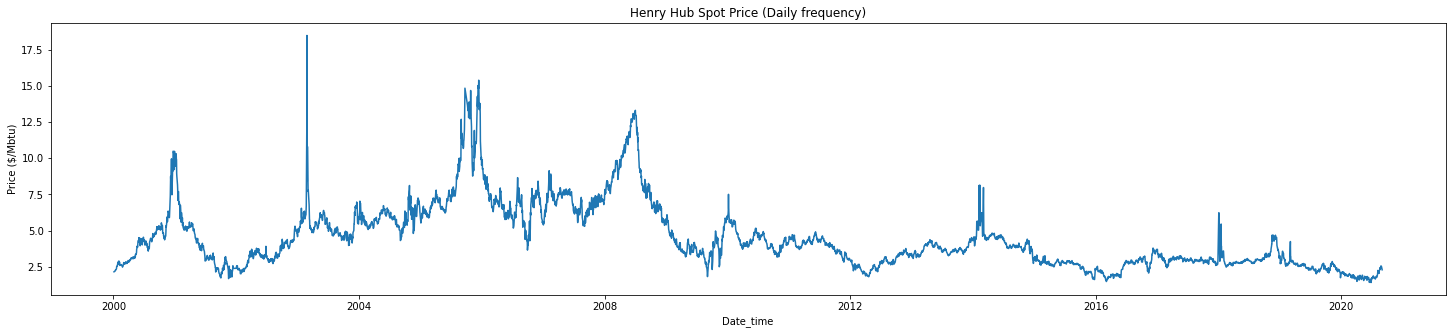

In [4]:
data_plot.plot(dataset)

In [5]:
from matplotlib import pyplot

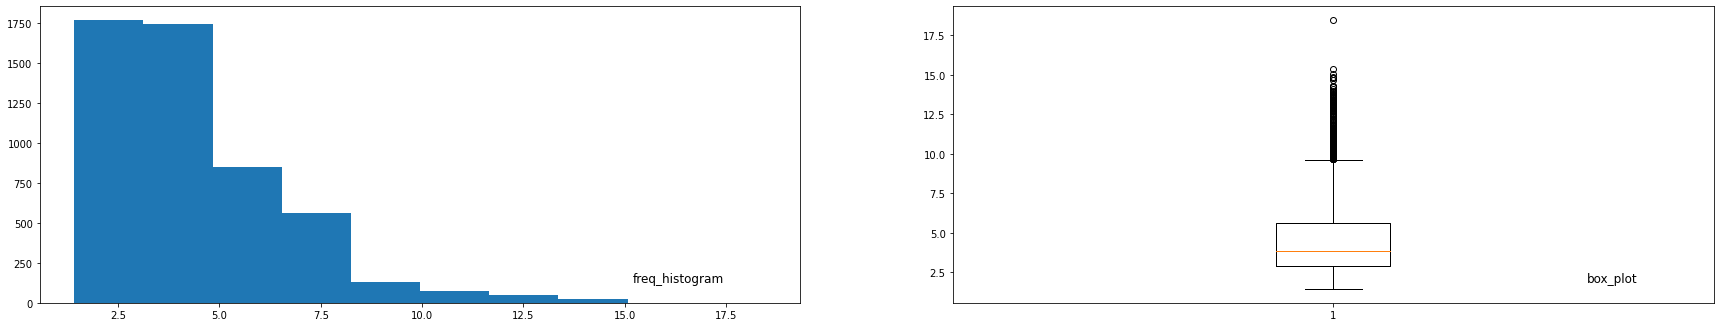

In [6]:
fig, ax = data_util.vis_behaviour(dataset, dataset.columns[0])

In [7]:
ax.get(1,1)

AttributeError: 'AxesSubplot' object has no attribute 'get'

In [8]:
# data_util.describe(dataset)

In [9]:
dataset.index.min(), dataset.index.max()

(Timestamp('2000-01-04 00:00:00'), Timestamp('2020-08-31 00:00:00'))

In [10]:
from sklearn import preprocessing 
scaler = preprocessing.RobustScaler(quantile_range=(25, 75))
train, test = data_util.split(dataset, dataset.columns[0], scaler=scaler, test_size=0.25) #0.05

Train_shape:  (3897, 1)
Test_shape:  (1299, 1)
Data Standardization with  RobustScaler(quantile_range=(25, 75))


In [11]:
col_name = dataset.columns[0]
n_steps = 30
X_train, y_train = data_util.create_dataset(train[[col_name]], train[col_name], n_steps)
X_test, y_test = data_util.create_dataset(test[[col_name]], test[col_name], n_steps)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print("-------------------")

X_train shape: (3867, 30, 1)
X_test shape: (1269, 30, 1)
y_train shape: (3867,)
y_test shape: (1269,)
-------------------


In [12]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
units = 64
dropout = 0.2
loss = 'mae'
optimizer = 'adam'

from tensorflow import keras
from models import keras_lstm_ae
model = keras_lstm_ae.create_lstm_ae(input_shape=(n_timesteps, n_features), dropout=dropout, units=units)
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.compile(loss = loss, optimizer = optimizer)
model.summary()

Model: "lstm_ae_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)           

In [13]:
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')], shuffle=False) #X_train

Epoch 1/60
109/109 [==============================] - 5s 30ms/step - loss: 0.2438 - val_loss: 0.0954
Epoch 2/60
109/109 [==============================] - 2s 21ms/step - loss: 0.1415 - val_loss: 0.0782
Epoch 3/60
109/109 [==============================] - 2s 22ms/step - loss: 0.1191 - val_loss: 0.0767
Epoch 4/60
109/109 [==============================] - 2s 22ms/step - loss: 0.1113 - val_loss: 0.0671
Epoch 5/60
109/109 [==============================] - 2s 23ms/step - loss: 0.1048 - val_loss: 0.0653
Epoch 6/60
109/109 [==============================] - 2s 23ms/step - loss: 0.1011 - val_loss: 0.0645
Epoch 7/60
109/109 [==============================] - 2s 22ms/step - loss: 0.0971 - val_loss: 0.0587
Epoch 8/60
109/109 [==============================] - 2s 22ms/step - loss: 0.0960 - val_loss: 0.0569
Epoch 9/60
109/109 [==============================] - 2s 23ms/step - loss: 0.0951 - val_loss: 0.0601
Epoch 10/60
109/109 [==============================] - 2s 22ms/step - loss: 0.0906 - val_lo

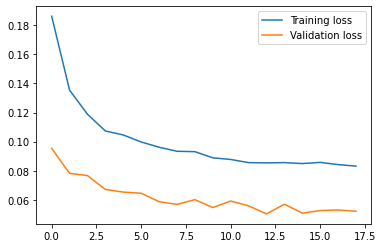

In [14]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='Training loss')
pyplot.plot(history.history['val_loss'], label='Validation loss')
pyplot.legend();

In [15]:
model.evaluate(X_test, y_test)


40/40 [==============================] - 0s 5ms/step - loss: 0.0507


0.050715502351522446

Training loss:  0.19064591086146293

Reconstruction error threshold: 3.4397510727822493


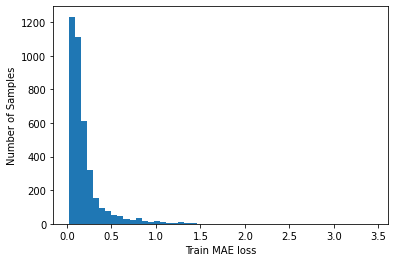

In [16]:
# CALCULATING THRESHOLD (WAY1)

import numpy as np
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
avg_loss = train_mae_loss.mean()
print("Training loss: ", avg_loss); print()

pyplot.hist(train_mae_loss, bins=50)
pyplot.xlabel('Train MAE loss')
pyplot.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

In [19]:
import math
import sklearn
# MAE on the test data:
X_test_pred = model.predict(X_test)
print('Predict shape (X_test_pred):', X_test_pred.shape); print();
mae = np.mean(np.abs(X_test_pred - X_test), axis=1)
# reshaping prediction
pred = X_test_pred.reshape((X_test_pred.shape[0] * X_test_pred.shape[1]), X_test_pred.shape[2])
print('Prediction:', pred.shape); print();
print('Test data shape (X_test):', X_test.shape); print();
# reshaping test data
X_test_reshape = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data (X_test_reshape):', X_test_reshape.shape); print();
# error computation
errors = X_test_reshape - pred
print('Error:', errors.shape); print();
# rmse on test data
RMSE = math.sqrt(sklearn.metrics.mean_squared_error(X_test_reshape, pred))
print('Test RMSE: %.3f' % RMSE);

Predict shape (X_test_pred): (1269, 30, 1)

Prediction: (38070, 1)

Test data shape (X_test): (1269, 30, 1)

Test data (X_test_reshape): (38070, 1)

Error: (38070, 1)

Test RMSE: 0.144


0.015563283277594557 1.1090525615906368


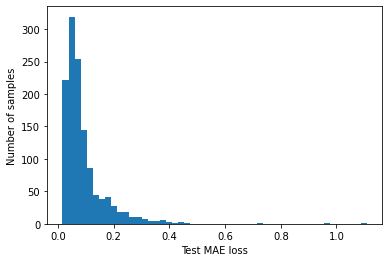

In [20]:
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

pyplot.hist(test_mae_loss, bins=50)
pyplot.xlabel('Test MAE loss')
pyplot.ylabel('Number of samples');
print(np.min(test_mae_loss), np.max(test_mae_loss))

In [56]:
# CALCULATING THRESHOLD (WAY1)
dist = np.linalg.norm(X_test_reshape - pred, axis=1)
scores = dist.copy();
print("Score", scores.shape)
scores.sort()
cut_off = int(0.9*len(scores))
print("cut_off value: ", cut_off)
threshold = scores[cut_off]
print(f'Threshold: {threshold}')

Score (38070,)
cut_off value:  34263
Threshold: 0.20367980262507568


In [57]:
test_score_df = pd.DataFrame(test[n_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df[dataset.columns[0]] = test[n_steps:][dataset.columns[0]]


In [58]:
test_score_df.tail()


,price,loss,threshold,anomaly
Day,,,,
2020-08-25,-0.695652,0.222724,0.20368,True
2020-08-26,-0.702899,0.219697,0.20368,True
2020-08-27,-0.702899,0.207063,0.20368,True
2020-08-28,-0.724638,0.196682,0.20368,False
2020-08-31,-0.782609,0.173406,0.20368,False


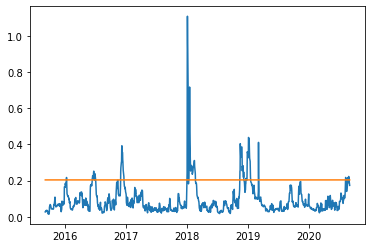

In [59]:
pyplot.plot(test_score_df['loss'])
pyplot.plot(test_score_df['threshold'])

In [60]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,price,loss,threshold,anomaly
Day,,,,
2016-01-12,-0.746377,0.217064,0.20368,True
2016-06-14,-0.692029,0.212914,0.20368,True
2016-06-15,-0.666667,0.214570,0.20368,True
2016-06-16,-0.666667,0.226458,0.20368,True
2016-06-17,-0.677536,0.224993,0.20368,True


In [61]:
test_score_df

,price,loss,threshold,anomaly
Day,,,,
2015-09-07,-0.648551,0.026394,0.20368,False
2015-09-08,-0.623188,0.026065,0.20368,False
2015-09-09,-0.623188,0.031024,0.20368,False
2015-09-10,-0.634058,0.033851,0.20368,False
2015-09-11,-0.648551,0.033360,0.20368,False
...,...,...,...,...
2020-08-25,-0.695652,0.222724,0.20368,True
2020-08-26,-0.702899,0.219697,0.20368,True
2020-08-27,-0.702899,0.207063,0.20368,True


In [62]:
anomalies

,price,loss,threshold,anomaly
Day,,,,
2016-01-12,-0.746377,0.217064,0.20368,True
2016-06-14,-0.692029,0.212914,0.20368,True
2016-06-15,-0.666667,0.214570,0.20368,True
2016-06-16,-0.666667,0.226458,0.20368,True
2016-06-17,-0.677536,0.224993,0.20368,True
...,...,...,...,...
2020-08-19,-0.735507,0.216179,0.20368,True
2020-08-20,-0.764493,0.215773,0.20368,True
2020-08-25,-0.695652,0.222724,0.20368,True


In [65]:
test_score_df.index

DatetimeIndex(['2015-09-07', '2015-09-08', '2015-09-09', '2015-09-10',
               '2015-09-11', '2015-09-14', '2015-09-15', '2015-09-16',
               '2015-09-17', '2015-09-18',
               ...
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-24', '2020-08-25', '2020-08-26', '2020-08-27',
               '2020-08-28', '2020-08-31'],
              dtype='datetime64[ns]', name='Day', length=1269, freq=None)

In [92]:
anomalies

,price,loss,threshold,anomaly
Day,,,,
2016-01-12,-0.746377,0.217064,0.20368,True
2016-06-14,-0.692029,0.212914,0.20368,True
2016-06-15,-0.666667,0.214570,0.20368,True
2016-06-16,-0.666667,0.226458,0.20368,True
2016-06-17,-0.677536,0.224993,0.20368,True
...,...,...,...,...
2020-08-19,-0.735507,0.216179,0.20368,True
2020-08-20,-0.764493,0.215773,0.20368,True
2020-08-25,-0.695652,0.222724,0.20368,True


In [101]:
%pip install vega_datasets

import altair as alt
import pandas as pd
import numpy as np

a = alt.Chart(test_score_df.reset_index()).mark_line().encode( 
    x="Day", y=dataset.columns[0]) 
b = alt.Chart(anomalies.reset_index()).mark_point(color="red").encode( 
    x="Day", 
    y=dataset.columns[0],
    color=alt.Color('anomaly:N', scale=alt.Scale(scheme='reds'), legend=alt.Legend(title="Anomaly"))
) 


a+b

Note: you may need to restart the kernel to use updated packages.


alt.LayerChart(...)

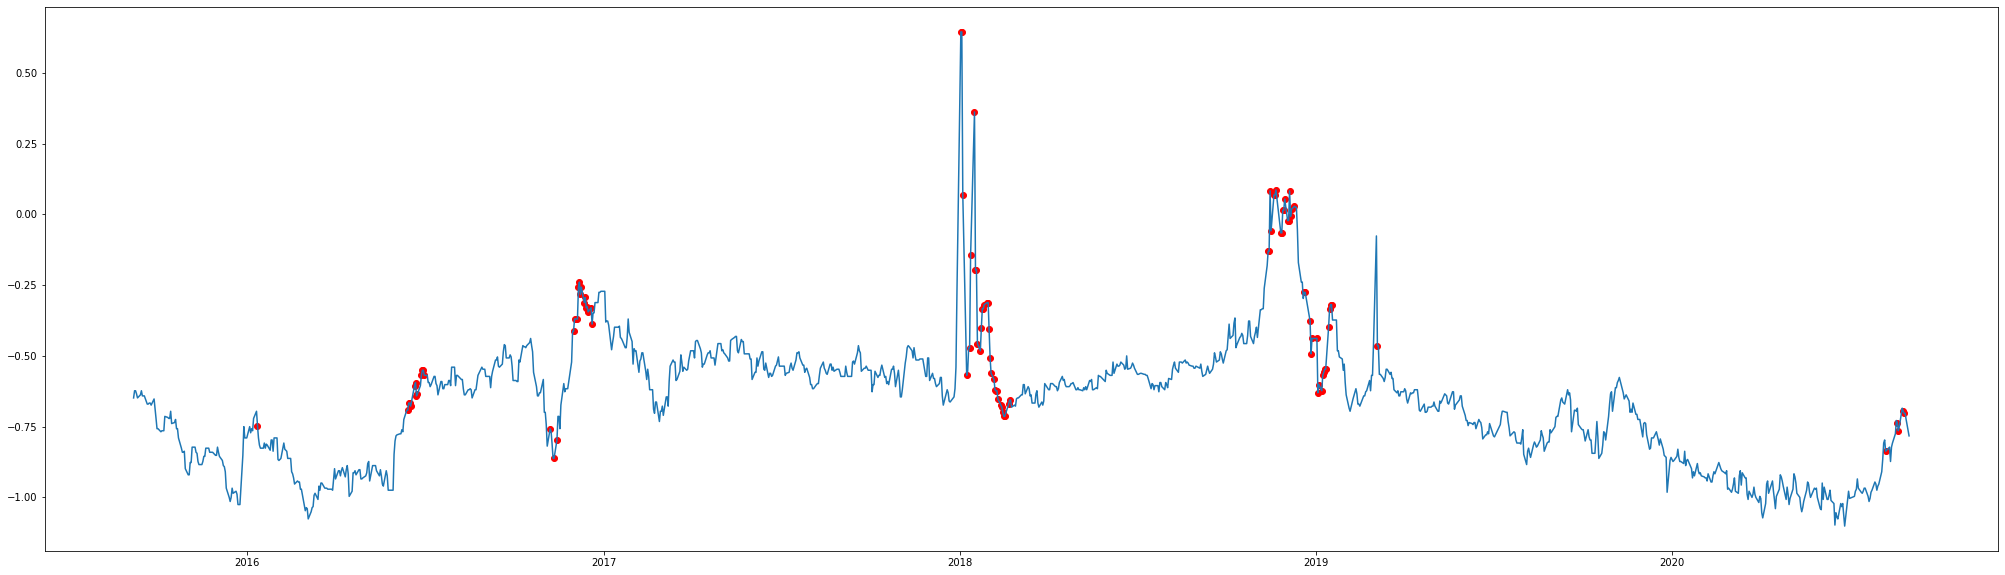

In [61]:
pyplot.figure(figsize=(35,10))
pyplot.plot(test_score_df.index, (test_score_df[dataset.columns[0]]))
pyplot.scatter(anomalies.index, (anomalies[dataset.columns[0]]), marker='o', color="red")

X_test_reshaped: (38070, 1)

Prediction: (38070, 1)



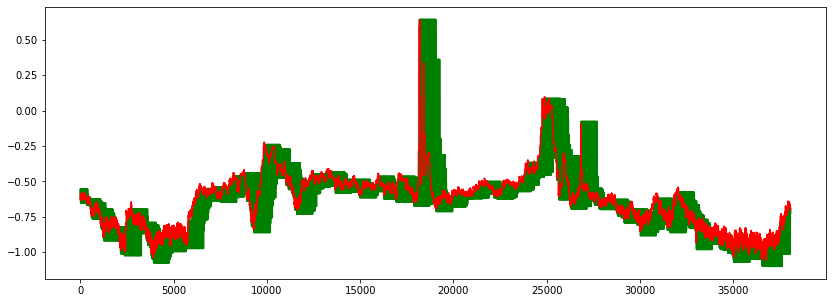

In [62]:
X_test_reshaped = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('X_test_reshaped:', X_test_reshaped.shape); print();
print('Prediction:', pred.shape); print();

pyplot.figure(figsize=(14,5))
pyplot.plot(X_test_reshaped, color = "green")
pyplot.plot(pred, color = "red")
